# SCADAA Report

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import odeint, solve_ivp, quad
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from exercise2 import DGM_Layer, Net_DGM
from exercise2 import FFN


## Exercise 1.1

In [2]:
class LQR:
    def __init__(self, H, M, sigma, C, D, R, T) -> None:
        self.H = H 
        self.M = M
        self.sigma = sigma
        self.C = C 
        self.D = D 
        self.R = R
        self.T = T
    

    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat, dtype=torch.float32).reshape((2, 2))  # Convert S_flat to a PyTorch tensor
        dS = (-2 * (self.H.t() @ S) + S @ (self.M) @ (torch.inverse(self.D)) @ (np.transpose(self.M)) @ S - self.C)
        return dS.flatten().detach().numpy()
 

    def solve_ricatti_ode(self, time_grid):
        """
        Solves the LQR problem by integrating the 
        Riccati equation backwards in time.
        """
        # Time points (reversed for backward integration)
        # t_points = np.linspace(0, self.T, 1000)[::-1]  
        intial_cond = self.R.flatten().detach().numpy()

        sol = solve_ivp(
            self.riccati_ode, [self.T.item(), time_grid[0].item()], 
            intial_cond, t_eval=time_grid.numpy()[::-1], method='RK45'
            )
        
        S = torch.tensor(sol.y)

        return S

    def visualize_results(self, t_points, S):
        """
        Visualizes the solution of the Riccati equation 
        or the state/control trajectories.
        """
        # S_00 = [s[0, 0].item() for s in S]
        plt.plot(t_points, S[0, :])
        plt.xlabel('Time')
        plt.ylabel('S[0,0]')
        plt.title('Solution of Riccati Equation over Time')
        plt.show()
       

    def markov_control(self, t_batch, x_batch):
        a=torch.tensor([])
        for t in range(len(t_batch)):
            time_grid = torch.linspace(float(t_batch[t]), self.T, 1000, dtype=torch.float32)
            S = self.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float()
            S_ordered =torch.flip(S,dims=[0])
            x_batch_n = x_batch[t]
            a_ = -((torch.inverse(self.D.float()) @ self.M.T) @ S_ordered[0]) @ x_batch_n.T
            a=torch.cat((a,a_.unsqueeze(0))) 
        return a.transpose(1,2)


    def value_function(self, t_batch, x_batch):
        v=torch.tensor([])
        for t in range(len(t_batch)):
            time_grid = torch.linspace(float(t_batch[t]), self.T, 1000, dtype=torch.float32)
            S = self.solve_ricatti_ode(time_grid).T.reshape(len(time_grid),2,2).float()
            S_ordered =torch.flip(S,dims=[0])
            sigma = self.sigma
            x_batch_n = x_batch[t]

            # Compute the first term: x.transpose(S)x
            x_S_x = torch.matmul(torch.matmul(x_batch_n.unsqueeze(0), S_ordered[0]), x_batch_n.unsqueeze(0).transpose(-1, -2)).squeeze()

        # Compute the integral term using Einstein summation notation with smaller time steps
            integral_term = 0
            for i in range(len(time_grid) - 1):
                dt = time_grid[i + 1] - time_grid[i]
                int_term=sigma@sigma.T@S_ordered[i]
                trace_term = torch.einsum('bij->b',int_term.unsqueeze(0))
                integral_term += trace_term * dt

            # Compute the total value function: v(t, x) = x.transpose(S)x + trace_term
            v=torch.cat((v,x_S_x + integral_term)) 
        return v


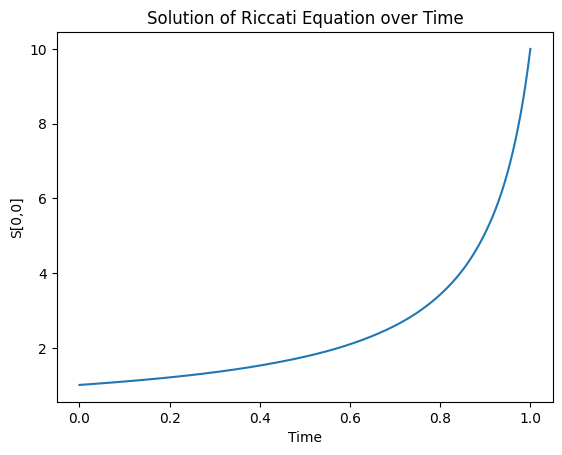

Optimal Markov Control:
tensor([[[-2.5995, -2.5995]]])
Value Function:
tensor([5.1990])


In [3]:
# Example Usage:
# Define problem matrices
# H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# C = torch.tensor([[0, 0], [0, 0]], dtype=torch.float32)
# R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
# T = torch.tensor(100, dtype=torch.float32)

#Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.1
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.001
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(1.0, dtype=torch.float32)
x0 = torch.tensor([1, 1], dtype=torch.float32)
t=torch.tensor(0.7, dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*10

# Initialize LQRController
# controller = LQRController(H, M, D, C, R, T)

# Define time grid
time_grid = torch.linspace(0, T, 10000)

lqr_system = LQR(H, M, sigma, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid)
S_sol_v2 = S_solution.T.reshape(len(time_grid),2,2)
S_sol_ordered =torch.flip(S_sol_v2,dims=[0])
lqr_system.visualize_results(torch.flip(time_grid, [0]), S_solution)

# Create sample input tensors
# t_batch = torch.tensor([0.5, 0.8, 1.0], dtype=torch.float32)  # Sample time values
# x_batch = torch.tensor([
#     [[1.0, 2.0]],  
#     [[1.0, 0.0]], 
#     [[3.0, 2.0]]  
# ], dtype=torch.float32)  # Sample spatial values

t_batch = torch.tensor([0.7], dtype=torch.float32)  # Sample time values
x_batch = torch.tensor([
    [[1.0, 1.0]] 
], dtype=torch.float32)  # Sample spatial values

# Compute the markov control
markov_control = lqr_system.markov_control(t_batch, x_batch)

# Print the computed value function
print("Optimal Markov Control:")
print(markov_control)

# Compute the value function
value_func = lqr_system.value_function(t_batch, x_batch)

# Print the computed value function
print("Value Function:")
print(value_func)



In [4]:
t_batch.shape, x_batch.shape

(torch.Size([1]), torch.Size([1, 1, 2]))

## Exercise 1.2

1. Error

2. Time

In [5]:
#Create error function 
def calculate_error(X):
    #We might want to have a better error function tbh
    error = np.linalg.norm(X - np.zeros(X.shape))
    return error

In [6]:

#Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.1
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0.001
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(1.0, dtype=torch.float32)
x0 = torch.tensor([1, 1], dtype=torch.float32)
t=torch.tensor(0.7, dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*0
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)*10


# Define time grid
time_grid_S = torch.linspace(0, T, 10000)
lqr_system = LQR(H, M, sigma, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid_S)
S_sol_v2 = S_solution.T.reshape(len(time_grid_S),2,2).float()
S_sol_ordered =torch.flip(S_sol_v2,dims=[0])


In [7]:
# X Generation
def generate_x(T, N_steps, H, M, D, S_solution, sigma, x0):

    x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1) 
    tau = T / N_steps
    X = x0.unsqueeze(0)
    brownian = torch.randn(N_steps, 2, dtype=torch.float32)*torch.sqrt(tau)

    for i in range(N_steps-1):
        dw = (brownian[i+1] - brownian[i]).view(2, 1)  # Ensure dw is a 2x1 vector
        # Calculate control action, ensuring it results in a 2x1 vector
        a_s = -torch.inverse(D) @ M.T @ S_sol_ordered[i] @ X[-1]
        # Update state, ensuring result is a 2x1 vector
        next_val = X[-1] + tau * (H @ X[-1] + M @ a_s) + sigma @ dw  # Use matrix-vector product for sigma @ dw
        
        X=torch.cat((X,next_val.view(2, 1).unsqueeze(0))) # Ensure next_val remains a 2x1 column vector

    return X.transpose(1,2)

# Call the function with corrected inputs
N_steps = 100
result = generate_x(T, N_steps, H.float(), M.float(), D.float(), S_solution.float(), sigma.float(), x0)
print(result)

tensor([[[1.0000, 1.0000]],

        [[0.9910, 0.9906]],

        [[0.9822, 0.9819]],

        [[0.9731, 0.9728]],

        [[0.9640, 0.9638]],

        [[0.9553, 0.9549]],

        [[0.9464, 0.9464]],

        [[0.9377, 0.9378]],

        [[0.9291, 0.9291]],

        [[0.9208, 0.9206]],

        [[0.9122, 0.9121]],

        [[0.9038, 0.9037]],

        [[0.8956, 0.8956]],

        [[0.8875, 0.8874]],

        [[0.8793, 0.8791]],

        [[0.8711, 0.8712]],

        [[0.8633, 0.8633]],

        [[0.8555, 0.8552]],

        [[0.8476, 0.8473]],

        [[0.8400, 0.8397]],

        [[0.8323, 0.8320]],

        [[0.8245, 0.8244]],

        [[0.8168, 0.8169]],

        [[0.8095, 0.8093]],

        [[0.8022, 0.8019]],

        [[0.7945, 0.7946]],

        [[0.7873, 0.7871]],

        [[0.7800, 0.7801]],

        [[0.7731, 0.7730]],

        [[0.7658, 0.7657]],

        [[0.7590, 0.7587]],

        [[0.7521, 0.7519]],

        [[0.7451, 0.7450]],

        [[0.7383, 0.7382]],

        [[0.73

/tmp/ipykernel_1537/2947327018.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


### Exercise 1.2.1

The error will be the difference between between the cost function and the value function, and this should converge for bigger time steps.

### Exercise 1.2.2

In [33]:
# 1.2.2 CODE DO NOT RUN IN GITHUB IF USING N_SAMPLES=100000

N_samples=100 #CHANGE FOR LOCAL RUNNING
N_steps=[1, 10, 50, 100, 500, 1000, 5000]
cost=torch.tensor([])
S_sol_cs = CubicSpline(time_grid_S, S_sol_ordered)
exp_cost=torch.tensor([])
for t in range(len(N_steps)):
    time_grid = torch.linspace(0, T, N_steps[t]+1)
    dt= time_grid[1:]-time_grid[:-1]
    S_sol_cs_vals = torch.tensor((S_sol_cs(time_grid.numpy())),dtype=torch.float32)
    for i in range(N_samples):
        result = generate_x(T, N_steps[t]+1, H.float(), M.float(), D.float(), 
                            S_sol_cs_vals.float(), sigma.float(), x0)
        alp = (-torch.inverse(D) @ M.T @ S_sol_cs_vals @result.transpose(1,2)).transpose(1,2)
        int_ = result@C@result.transpose(1,2) + alp@D@alp.transpose(1,2)
        J = torch.tensor(0.5)*dt@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))
        cost=torch.cat((cost,J))
    exp_cost=torch.cat((exp_cost,torch.mean(cost).unsqueeze(0)))

/tmp/ipykernel_1869/2947327018.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


tensor([25.2830, 12.7300,  8.3109,  6.0869,  4.7281,  3.8024,  2.9955])


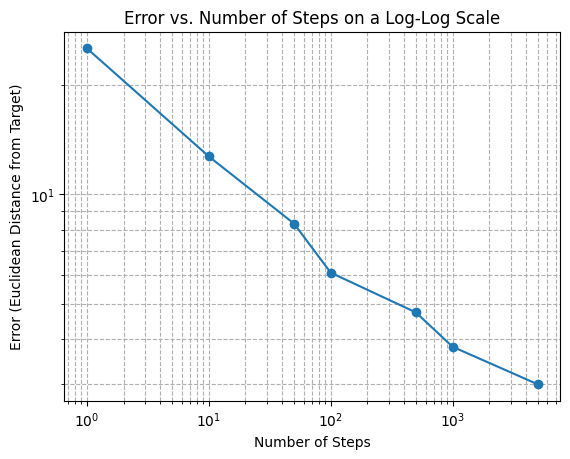

In [34]:
# OUR FIRST 1.2 BABY :D


# Compute the error
error=abs(exp_cost-value_func)
print(error) 
#Plot the error
plt.loglog(N_steps, error, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale')
plt.grid(True, which="both", ls="--")
plt.show()

Exercise 1.2.3

In [35]:
# 1.2.3 CODE DO NOT RUN IN GITHUB IF USING N_SAMPLES=100000

#N_samples=[10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000] #DO NOT RUN
N_samples = [10,50,100]
N_steps = 5000
cost_samples = torch.tensor([])
exp_cost_samples = torch.tensor([])

# Time grid specifications
time_grid = torch.linspace(0, T, N_steps+1)
dt = time_grid[1:]-time_grid[:-1]
S_sol_cs_vals = torch.tensor((S_sol_cs(time_grid.numpy())),dtype=torch.float32)

for j in range(len(N_samples)):
    for i in range(N_samples[j]):
        result = generate_x(T, N_steps+1, H.float(), M.float(), D.float(), 
        S_sol_cs_vals.float(), sigma.float(), x0)

        alp = (-torch.inverse(D) @ M.T @ S_sol_cs_vals @result.transpose(1,2)).transpose(1,2)
        int_ = result@C@result.transpose(1,2) + alp@D@alp.transpose(1,2)

        J = result[-1]@R@result[-1].T + torch.tensor(0.5)*dt@((int_.squeeze(1)[1:]+int_.squeeze(1)[:-1]))
        cost_samples=torch.cat((cost_samples,J))
    
    exp_cost_samples=torch.cat((exp_cost_samples,torch.mean(cost_samples).unsqueeze(0)))

/tmp/ipykernel_1869/2947327018.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32).view(2, 1)


tensor([5.1073, 5.1072, 5.1072])


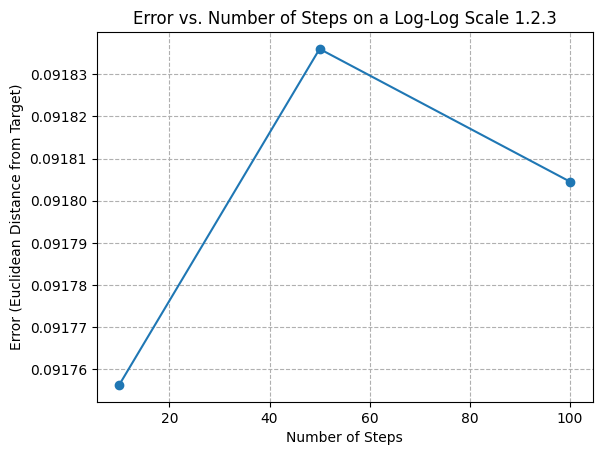

In [36]:
# OUR FIRST 1.2.3 BABY :D

print(exp_cost_samples) # why is the first one better than the second?

# Compute the error
error_samples = abs(exp_cost_samples-value_func)

#Plot the error
plt.plot(N_samples, error_samples, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale 1.2.3')
plt.grid(True, which="both", ls="--")
plt.show()

Exercise 2

In [8]:
# Function to generate training data
def generate_training_data(T, num_samples):
    t = torch.tensor(np.random.uniform(0, T, num_samples), dtype=torch.float32)
    x = torch.tensor(np.random.uniform(-3, 3, (num_samples, 2)), dtype=torch.float32).unsqueeze(-1).transpose(1,2)
    return t, x

Epoch 0, Loss: 705.7901000976562
Epoch 100, Loss: 0.6088146567344666
Epoch 200, Loss: 1.4445703527599107e-05
Epoch 300, Loss: 2.5011104298755527e-10


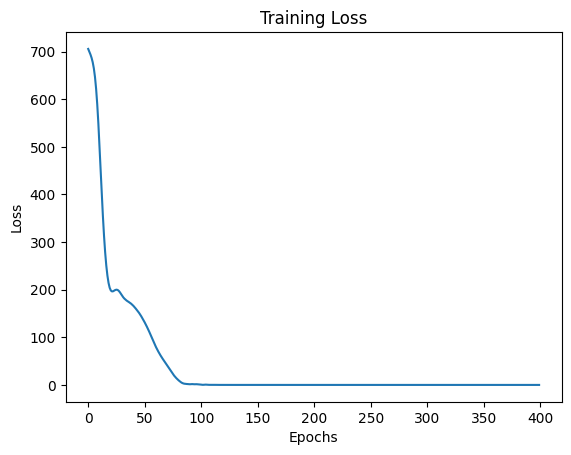

In [120]:
# Function to train the neural network
def train_net_dgm(net_dgm, t_train, x_train, epochs=400, lr=0.001):
    optimizer = optim.Adam(net_dgm.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = np.array([])

    for epoch in range(epochs):
        optimizer.zero_grad()
        v_real=lqr_system.value_function(t_train, x_train).unsqueeze(1)
        v_pred = net_dgm(t_train.unsqueeze(1),x_train.view(num_samples,2))  # Predict value function
        loss = criterion(v_pred, v_real)  # Compute loss
        loss.backward()
        optimizer.step()
        losses= np.append(losses,loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Generate training data
T = 1
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
vf=lqr_system.value_function(t_train, x_train)

# Initialize the neural network
net_dgm = Net_DGM(dim_x=2, dim_S=100, hidden_size=100)

# Train the neural network
losses = train_net_dgm(net_dgm, t_train, x_train)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [117]:
torch.cat([t_train.unsqueeze(1),x_train.view(10,2)],1)

tensor([[ 0.5468, -2.7768,  0.3686],
        [ 0.8953,  2.8838,  0.4931],
        [ 0.4394, -0.9393, -1.6105],
        [ 0.4218,  1.6464,  1.2668],
        [ 0.1100, -0.2252,  1.4129],
        [ 0.7930, -1.2488,  1.3370],
        [ 0.7774,  0.7748, -0.1663],
        [ 0.6238,  0.6567, -2.3666],
        [ 0.4605, -1.4779, -1.9423],
        [ 0.1500, -2.9327, -1.3654]])

tensor([[[-4.1627,  2.4162]],

        [[ 2.3925, -1.6659]],

        [[-6.5968,  3.0112]],

        [[ 1.7308, -1.5858]],

        [[ 0.1331,  8.3077]],

        [[ 0.2928, -2.4716]],

        [[-6.2842,  5.6365]],

        [[ 0.2150, -1.1118]],

        [[-1.1702,  6.8162]],

        [[-1.7648,  5.8355]]])
Epoch 0, Loss: 16.260650634765625
Epoch 100, Loss: 0.015555545687675476
Epoch 200, Loss: 0.004952629562467337


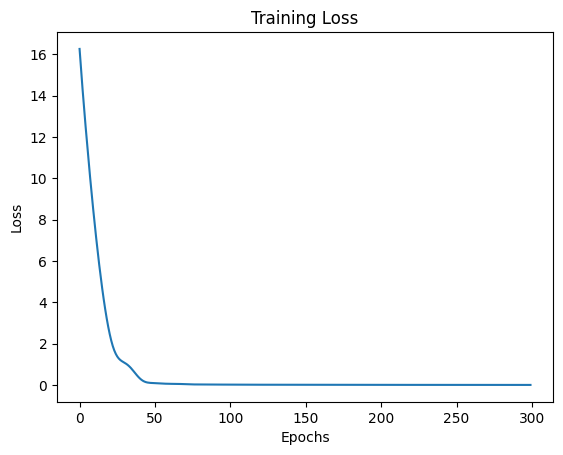

In [94]:
# Function to train the neural network
def train_ffn_net(net_ffn, t_train, x_train, epochs=300, lr=0.001):
    optimizer = optim.Adam(net_ffn.parameters(), lr=lr)
    tx_train = torch.cat((t_train.unsqueeze(1),x_train.squeeze(1)),dim=1)
    criterion = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        a_real=lqr_system.markov_control(t_train, x_train).squeeze(1)
        a_pred = net_ffn(t_train.unsqueeze(1),x_train.view(num_samples,2))  # Predict markov control
        loss = criterion(a_pred, a_real)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Generate training data
T = 1
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
print(lqr_system.markov_control(t_train, x_train))

# Define the sizes for the FFN network
sizes = [5, 100, 100, 2]  # Input size is 4 (markov control + time + 2 x), 2 hidden layers of size 100, output size is 2

# Initialize the neural network
net_ffn = FFN(sizes)

# Train the neural network
losses = train_ffn_net(net_ffn, t_train, x_train)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [89]:
a_real=lqr_system.markov_control(t_train, x_train).squeeze(1)
tx_train = torch.cat((t_train.unsqueeze(1),x_train.squeeze(1)),dim=1)
a_real,tx_train

(tensor([[ 2.3722e+00, -3.4369e+00],
         [-8.4266e+00,  4.8113e+00],
         [-3.1839e+00, -2.6481e+00],
         [ 5.0117e+00, -8.7557e-01],
         [-2.9542e+00, -2.4013e+00],
         [ 3.8273e+00, -7.2597e-03],
         [-8.0827e-01, -3.9852e-01],
         [-3.5364e+00, -3.8906e-01],
         [-4.3879e+00,  9.8963e+00],
         [-2.1770e+01,  3.6170e+00]]),
 tensor([[ 0.1400, -2.0687,  2.9972],
         [ 0.9676,  1.1089, -0.6332],
         [ 0.1235,  2.8190,  2.3446],
         [ 0.5941, -2.4105,  0.4211],
         [ 0.0444,  2.8059,  2.2807],
         [ 0.6193, -1.7533,  0.0033],
         [ 0.0475,  0.7657,  0.3775],
         [ 0.1834,  2.9582,  0.3254],
         [ 0.8581,  1.0388, -2.3429],
         [ 0.9942,  2.2997, -0.3821]]))

In [ ]:
class PDE():
    def __init__(self, net, T, sigma, H, M, C, D, R, alpha):
        self.net = net
        self.T = T
        self.sigma = sigma
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.alpha = alpha
    
    def pde_residual(self, t, x):
        t.requires_grad_(True)
        x.requires_grad_(True)
        
        u = self.net(t, x)  
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Compute the PDE residual term
        pde_res = (
            u_t + 0.5 * (sigma @ sigma.T @ u_xx.T).trace()
            + (u_x @ self.H @ x.T).sum()
            + (u_x @ self.M @ self.alpha.T)
            + (x @ (self.C @ x.T)).sum()
            + (self.alpha @ (self.D @ self.alpha.T))
        )

        return pde_res

    def boundary_condition(self, x):
        # Compute the boundary condition term
        u = self.net(self.T, x)  # Neural network output at the final time
        boundary_term = torch.square(u - x @ self.R)
        return boundary_term


In [11]:
class DGM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()

    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)
        hidden1 = self.activation(self.fc1(input_tensor))
        hidden2 = self.activation(self.fc2(hidden1))
        output = self.fc3(hidden2)
        return output

def loss_function(u, t, x, linear_pde):
    pde_residual = linear_pde.pde_residual(t, x)
    boundary_term = linear_pde.boundary_condition(x)
    loss = pde_residual.mean() + boundary_term.mean()  # Compute the mean loss
    return loss

def train_dgm(model, t_train, x_train, linear_pde, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        u_pred = model(t_train, x_train)
        loss = loss_function(u_pred, t_train, x_train, linear_pde)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Define hyperparameters
input_dim = 3  # Input dimension (time, space_x, space_y)
hidden_dim = 100  # Hidden layer dimension
output_dim = 1  # Output dimension (solution)
num_samples = 1000  # Number of training samples
T = 1  # End time
epochs = 1000  # Number of training epochs
lr = 0.001  # Learning rate

# Initialize the DGM model
model = DGM(input_dim, hidden_dim, output_dim)

# Create an instance of the HeatEquation2D class
linear_pde = PDE(model, T, sigma, H, M, C, D, R, alpha)

# Generate training data
t_train = torch.rand(num_samples, 1) * T
x_train = torch.rand(num_samples, 2)  # Assuming 2D space

# Train the DGM model
train_dgm(model, t_train, x_train, linear_pde, epochs, lr)


TypeError: diff(): argument 'n' (position 1) must be int, not Tensor